In [2]:
import numpy as np
import tensorflow as tf

In [3]:
# amazingly, this fixes plotting on Harish's Mac!
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
# this function seeks to ensure reproducibility
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [5]:
n_instances = 10
dt = 0.01
n_steps = 1000
d = 1
qdat = np.zeros((n_steps, n_instances, d))
pdat = np.zeros((n_steps, n_instances, d))
for i in range(n_instances):
    for j in range(n_steps):
        qdat[j, i, 0] = (i+1)*np.sin(j*dt)
        pdat[j, i, 0] = (i+1)*np.cos(j*dt)

In [6]:
import matplotlib.pyplot as plt

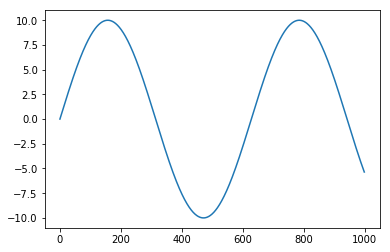

In [7]:
plt.plot(qdat[:, 9, :])
plt.show()

In [8]:
def tf_diff_axis_0(a):
    return a[1:]-a[:-1]

In [9]:
# # assume data is in the form: n_steps x n_instances x d
# qdat = np.array([[[0.3, -0.5, 1.0, 7.0],[3.7,-0.4,-0.15, -7.0]], 
#                  [[-7.0,3.14,2.5, 8.0],[3.7,-0.4,-0.15, -7.0]], 
#                  [[2.0,6.14,9.5,9.0],[3.7,-0.4,-0.15, -7.0]]])
# pdat = np.random.normal(size=qdat.shape)
# print(qdat.shape)
# n_steps, n_instances, d = qdat.shape

In [10]:
# set up a neural network model for a potential function V : R^d --> R
reset_graph()

# here we take both q and p to be n_steps x n_instances x d
qts = tf.placeholder(tf.float32, shape=(None, n_instances, d), name="qts")
pts = tf.placeholder(tf.float32, shape=(None, n_instances, d), name="pts")

# flatten in such a way that we get a two-dimensional matrix consisting of blocks
# each block consists of one instance of dimension n_steps x d
# the number of such blocks is n_instances
q = tf.transpose(tf.layers.flatten(tf.transpose(qts, perm=[2, 1, 0])),perm=[1, 0])

# keep track of outputs of each layer
output = []

# put the inputs in output[0]
output.append(q)

# here is a little Python magic that enables us to define a new function
# called "my_dense_layer" which is the same as the TF function tf.layers.dense
# except that we have preset activation=selu
# ...in short, we have partially evaluated tf.layers.dense...
from functools import partial
my_dense_layer = partial(tf.layers.dense,activation=tf.nn.tanh)

Instructions for updating:
Use keras.layers.flatten instead.


In [11]:
depth = 2
numneurons = [16, 16]

# here is where we define our deep neural network
with tf.name_scope("dnn"):
    
    # we iteratively create hidden layers
    for j in range(depth):
        thisname = "hidden" + str(j)
        
        # the input to hidden layer j is outputs[j]
        # the output of hidden layer j is stored in outputs[j+1]
        # this function handles the creation of all weight and bias variables,
        # for each hidden layer!
        output.append(my_dense_layer(output[j], 
                                     units=numneurons[j],
                                     name=thisname))

    # to get from the high-dimensional output of the final hidden layer
    # to a scalar output, we use this function, which basically uses 
    # a linear transformation of the form "w^T h + b"
    # --> h is the vector of outputs from the last hidden layer
    # --> w is a weight vector of the same dimension as h
    # --> b is a scalar
    Vpredraw = tf.layers.dense(output[depth], units=1, name='output')
    Vpred = tf.reshape(Vpredraw, shape=[n_instances, n_steps])

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [12]:
# automatically differentiate potential and generate gradV : R^d --> R^d
from tensorflow.python.ops.parallel_for.gradients import jacobian, batch_jacobian
gradVpredraw = batch_jacobian(Vpredraw, q)
gradVpred = tf.reshape(gradVpredraw, shape=[n_instances, n_steps, d])

Instructions for updating:
Use tf.cast instead.


In [13]:
# compute loss and set up optimizer
pdot = tf_diff_axis_0(pts)/dt
loss = tf.reduce_mean( tf.square( pdot + tf.transpose(gradVpred[:,:-1], perm=[1,0,2]) ) )
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
training_op = optimizer.minimize(loss)


In [14]:
# typical TF initialization
init = tf.global_variables_initializer()

# we set up TF to save its progress to disk
saver = tf.train.Saver()

In [14]:
with tf.Session() as sess:
    init.run()
    maxsteps = 50000
    for i in range(maxsteps):
        # we run the "training_op" defined above, corresponding to one optimization step
        # note that we must feed in xx and yy for the placeholders X and y
        sess.run(training_op, feed_dict={qts : qdat, pts : pdat})
        # periodically tell us what is happening to the loss function
        if (i % 1000) == 0:
            # note this is another way to grab the value of the loss function
            # we still have to feed in xx and yy for the placeholders X and y
            print(i, "Loss:", loss.eval(feed_dict={qts : qdat, pts : pdat}))
    # save final trained TF model to disk
    save_path = saver.save(sess, "./pot_model_final.ckpt")


0 Loss: 18.403639
1000 Loss: 1.8416827
2000 Loss: 0.40274748
3000 Loss: 0.0978397
4000 Loss: 0.018015433
5000 Loss: 0.008641675
6000 Loss: 0.006233785
7000 Loss: 0.004950989
8000 Loss: 0.004181364
9000 Loss: 0.0036779218
10000 Loss: 0.003323535
11000 Loss: 0.0030587115
12000 Loss: 0.0028512077
13000 Loss: 0.0026833229
14000 Loss: 0.0025445565
15000 Loss: 0.0024269703
16000 Loss: 0.0023257935
17000 Loss: 0.0022370582
18000 Loss: 0.0021594998
19000 Loss: 0.0020914825
20000 Loss: 0.002030546
21000 Loss: 0.0019745545
22000 Loss: 0.0019238511
23000 Loss: 0.0018784195
24000 Loss: 0.0018369188
25000 Loss: 0.0017986447
26000 Loss: 0.0017626242
27000 Loss: 0.0017303217
28000 Loss: 0.0016999651
29000 Loss: 0.0016716267
30000 Loss: 0.0016446405
31000 Loss: 0.00161971
32000 Loss: 0.001597004
33000 Loss: 0.0015748709
34000 Loss: 0.0015548149
35000 Loss: 0.0015348025
36000 Loss: 0.001515386
37000 Loss: 0.0014976826
38000 Loss: 0.0014808098
39000 Loss: 0.0014645715
40000 Loss: 0.0014488586
41000 Loss

In [19]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


INFO:tensorflow:Restoring parameters from ./pot_model_final.ckpt


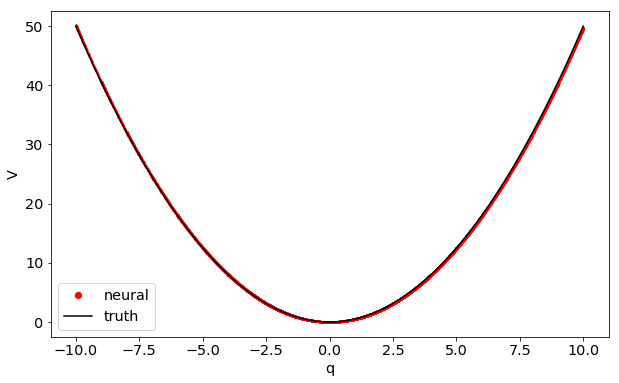

In [34]:
# here we grab the final model from disk and extract three things:
# the true values of x, the true values of y, and the predicted values of y
# n = 10

with tf.Session() as sess:
    saver.restore(sess, "./pot_model_final.ckpt")
    # xp = np.reshape(np.linspace(-4.0,4.0,n),[1,n,1])
    Vplot = sess.run(Vpred, feed_dict = {qts : qdat})

qdatpts = np.reshape(np.transpose(qdat,(1,0,2)),[10000])
Vplotpts = np.reshape(Vplot,[10000])
plt.figure(figsize=(10,6)) 
plt.plot(qdatpts,Vplotpts - np.min(Vplotpts),'r.',ms=2.5, label='neural')
np.savetxt(fname='modelpot1V.csv', X=Vplotpts, delimiter=',')
np.savetxt(fname='modelpot1r.csv', X=qdatpts, delimiter=',')
plt.plot(np.sort(qdatpts),0.5*np.sort(qdatpts)**2,'k-',lw=1.5, label='truth')
plt.legend(markerscale=5)
plt.xlabel('q')
plt.ylabel('V')
plt.savefig('shoplot.pdf')
plt.show()

In [26]:
# debugging code to check shape of kernels
dg = tf.get_default_graph()
alltens = [n.name for n in tf.get_default_graph().as_graph_def().node]
print(dg.get_tensor_by_name('hidden0/kernel:0'))
print(dg.get_tensor_by_name('hidden1/kernel:0'))
print(dg.get_tensor_by_name('output/kernel:0'))

Tensor("hidden0/kernel:0", shape=(4, 4), dtype=float32_ref)
Tensor("hidden1/kernel:0", shape=(4, 4), dtype=float32_ref)
Tensor("output/kernel:0", shape=(4, 1), dtype=float32_ref)


In [10]:
# need a few pieces here
# get (q,p) time series data as input

# compute -\grad V(q)
# compute loss function \| \dot{p} + \grad V(q) \|^2

